In [2]:
from utils.streamline_to_surface_utils import *
from utils.surface_label_utils import *
import os.path as op
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [29]:
subjects_dir = "/home/naxos2-raid25/ahmad262/IPS-VTC-fWMT/data/freesurfer"
subjects_list = ["subj01", "subj02", "subj03", "subj04", "subj05", "subj06", "subj07", "subj08"]
hemis = ["lh", "rh"]

# Function to set values greater than 6 to 6
def cap_at_six(x):
    return min(x, 6)

In [86]:
lh_eccentricities_df = pd.DataFrame(data=np.arange(0, 6.5, 1), columns=["Eccentricity"])
rh_eccentricities_df = pd.DataFrame(data=np.arange(0, 6.5, 1), columns=["Eccentricity"])

for subj in subjects_list:
    subj_dir = op.join(subjects_dir, subj)
    for hemi in hemis:
        prf_label = op.join(subj_dir, "label", hemi + ".prfeccentricity.smoothed.mgz") # non smoothed is just without .smoothed
        IPS0_label = op.join(subj_dir, "fyz", "anatomy", f"{hemi}-rois", "IPS0", f"{hemi}.Kastner2015.subsetted.IPS0.mgz")
        
        labels, count = label_endpoints_with_pRF_property(prf_label, IPS0_label)
        labels[:, 1] = np.where(labels[:, 1] > 0, 1, 0)
        
        propCoverage = f"propCoverage{subj}"
        df = pd.DataFrame(labels, columns=["Eccentricity", propCoverage])

        dfwithCoverage = df[df[propCoverage] > 0]
        #dfReasonable = dfwithEndpoints[dfwithEndpoints["Eccentricity"] < 6.25] # 6.25 because rounding to nearest 0.5, based on limitation of stimulus size in experiment
        dfReasonable = dfwithCoverage.applymap(cap_at_six)
        #dfReasonable = (dfReasonable*2).round()/2 # rounding to neatest 0.5
        dfReasonable = dfReasonable.round(0)
        dfReasonable = dfReasonable.groupby("Eccentricity").sum().reset_index()
        dfReasonable[propCoverage] = dfReasonable[propCoverage] / labels[:, 1].sum() # puts everything into proportions

        vars()[f"{hemi}_eccentricities_df"] = vars()[f"{hemi}_eccentricities_df"].merge(dfReasonable, on="Eccentricity", how="outer")
        

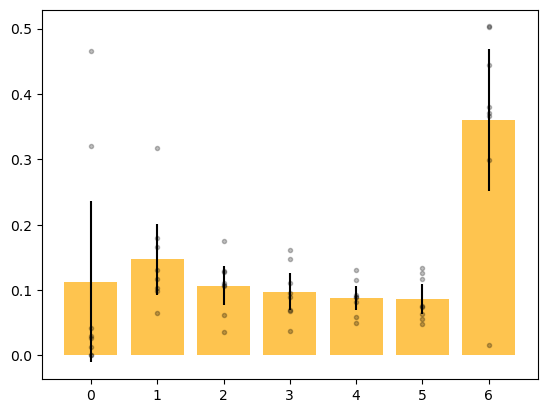

In [97]:
df = lh_eccentricities_df
transpose = df.transpose()
transpose = transpose.rename(columns=transpose.iloc[0])[1:]
a = transpose.describe()
means = a.loc['mean'].values.tolist()
stdevs = a.loc['std'].values.tolist()
counts = a.loc['count'].values.tolist()
index = np.arange(len(transpose.columns))

CI = []
for i in range(len(means)):
    CIval = 1.96*stdevs[i]/(counts[i]**(0.5)) # we might want to use the proportion CI calculation instead of means
    CI.append(CIval)
    
plt.bar(index, means, yerr=CI, color="#fec44f")
plt.scatter(transpose.melt()["variable"], transpose.melt()["value"], marker=".", alpha=0.25, color="black")

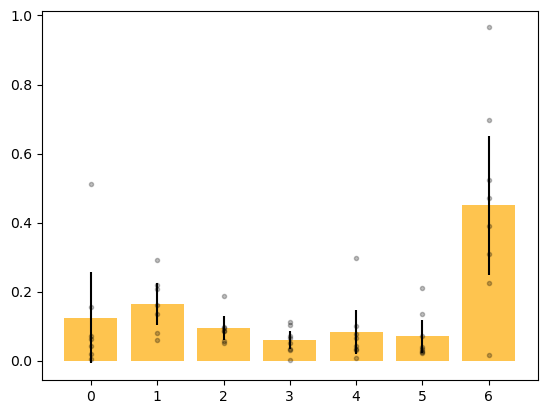

In [98]:
df = rh_eccentricities_df
transpose = df.transpose()
transpose = transpose.rename(columns=transpose.iloc[0])[1:]
a = transpose.describe()
means = a.loc['mean'].values.tolist()
stdevs = a.loc['std'].values.tolist()
counts = a.loc['count'].values.tolist()
index = np.arange(len(transpose.columns))

CI = []
for i in range(len(means)):
    CIval = 1.96*stdevs[i]/(counts[i]**(0.5)) # we might want to use the proportion CI calculation instead of means
    CI.append(CIval)
    
plt.bar(index, means, yerr=CI, color="#fec44f")
plt.scatter(transpose.melt()["variable"], transpose.melt()["value"], marker=".", alpha=0.25, color="black")